# Binary black hole detections

Matriculation: 2663452m

## Aims
The aims of this experiment are to procees the gravitational wave data from the first and second runs of the LIGO/Virgo gravitational wave detectors and to discover properties of the binary black hole systems that produced the signals.


Gravitational waves were first predicted by Einstien in his 1915 paper on General Relativity but in 2015 the first gravitational wave was detected by the LIGO research group. To detect gravitational waves over 50 years of research and development have gone into building detectors, which consist of a large highly accurate laser interferometer. from this changes in the diffraction pattern of the interfering light indirectly infer the distance between the mirrors has changed and as the mirrors are suspended in a vacuum and isolated from seismic activity, this change is coming from the stretching of space-time due to the gravitaional waves. This change is measured as strain similar to that in a material when it is stretched.

Start by importing all the relevant packages including the LIGO lalsuite, and setting default plot parameters.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
import scipy.optimize as opt
import scipy.constants as const
import os
import lal as lal
from scipy.signal import spectrogram
import gw_detections_functions as gw
import pandas as pd

all_title = 18
title_size = 16
axis_size = 12
annotation_size = 10
plt.rcParams["font.family"] = "Times New Roman"


## Looking at the data for the first ever gravitational wave detection GW150914

### Plotting and analysing the position of the peak
In this task the data waas loaded in and the strain of the gravitational wave was plotted agaisnt the time, and then by observation the peak where the coalescence of the merger was detected was found and the plot was limited to allow for a closer look at the peak.

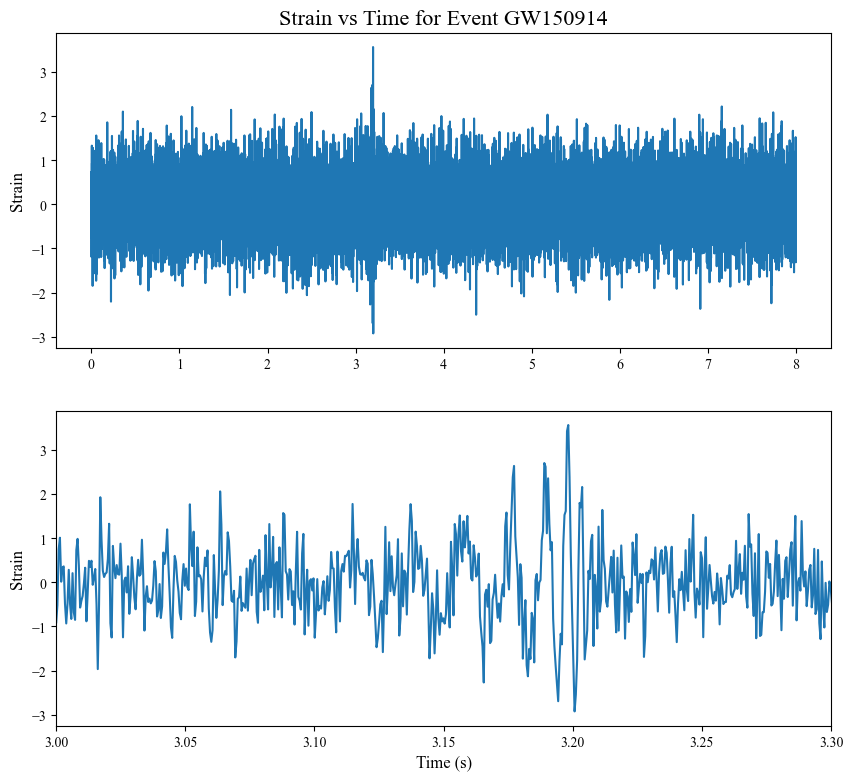

In [8]:
data = np.loadtxt('strain_data/GW150914_strain.txt')
time = data[:,0]
strain = data[:,1]

plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(time, strain)

plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time for Event GW150914', fontsize=title_size)

plt.subplot(2,1,2)
plt.plot(time, strain)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.xlim(3,3.3)
plt.show()

From this plot looking at the peak it can be observed that the merger occurred over a short period of time and and a very short time to return to the background signal. Also the peak amplitude was not much greater then that of the noise in the background, this again shows how difficult it is to detect gravitational waves.

### Creating a spectrogram of the data

In this task the scipy spectrogram function was used to generate the 'chirp' track of the data as seen in figure 1 of the labscript, this function takes in the strain data and the sampling frequency of the detector and returns the relevant data to enable a spectrogram to be plotted. By takeing the time interval fund abpve for when the merge occured and using this to limit the plot, the characteristic chip track of the gravitational wave can be seen.


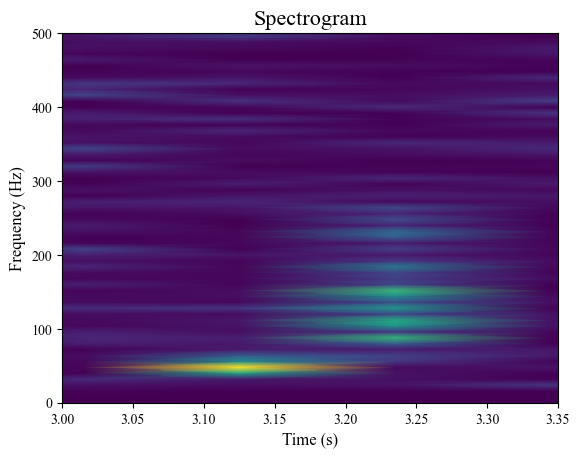

In [9]:
spec_f, spec_t, spec = sp.signal.spectrogram(strain, 2048)
plt.pcolormesh(spec_t, spec_f, spec, shading='gouraud')
plt.ylabel('Frequency (Hz)', fontsize=axis_size)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(3,3.35)
plt.ylim(0,500)
plt.title('Spectrogram', fontsize=title_size)
plt.show()


Where the track goes up on the spectrogram correlates to the time when the strain goes up in the plot above. The spectrogram plot shows some unusual behavior when plotted here, all values appear to be strected oon the time axis when comparing to the official plot, this is possibly due to some correction factor that hasn't been applied in this case or noise that hasn't yet been removed.

### Template plots of the strain vs time

In this task using the function make_template as supplied by the lalsuite package, the template plot of what to expect from the merger is plotted for GW150914. And then more plots were made for varying masses of black holes and the effect this has on the template can be seen.

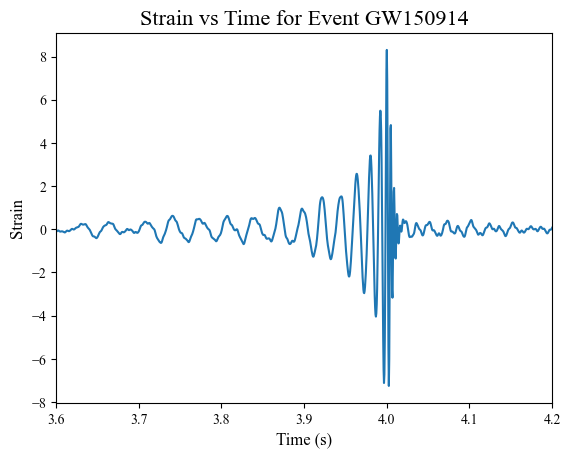

In [10]:
inv_psd = np.loadtxt('inv_psd/GW150914_inv_psd.txt',usecols=(1,))
t, template = gw.make_template(36,31,2048,8,inv_psd,400)

plt.figure()
plt.plot(t, template)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(3.6,4.2)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time for Event GW150914', fontsize=title_size)
plt.show()


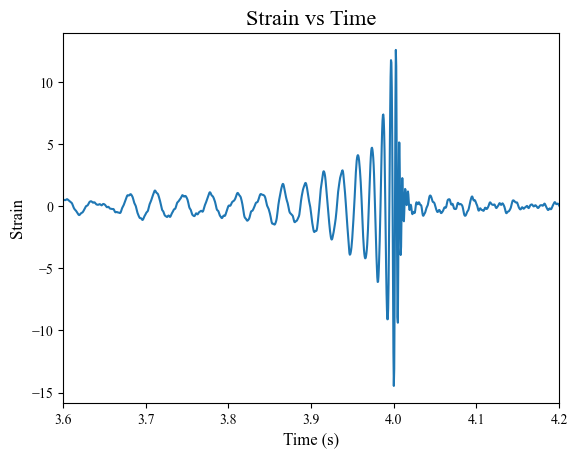

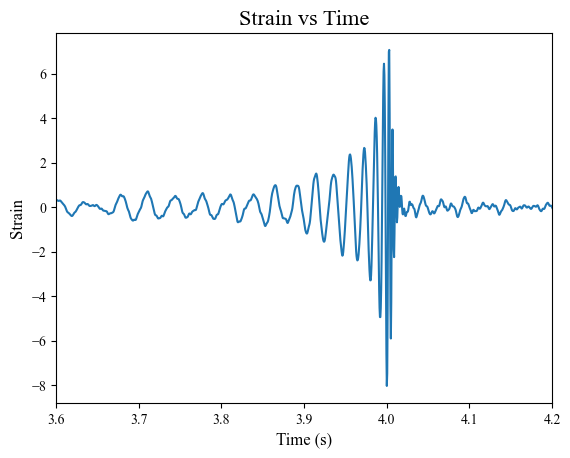

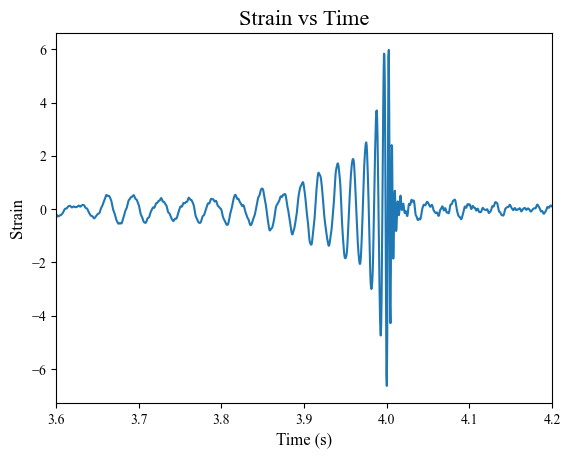

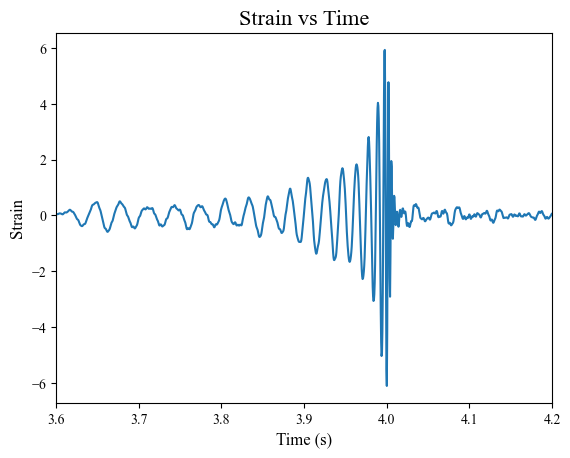

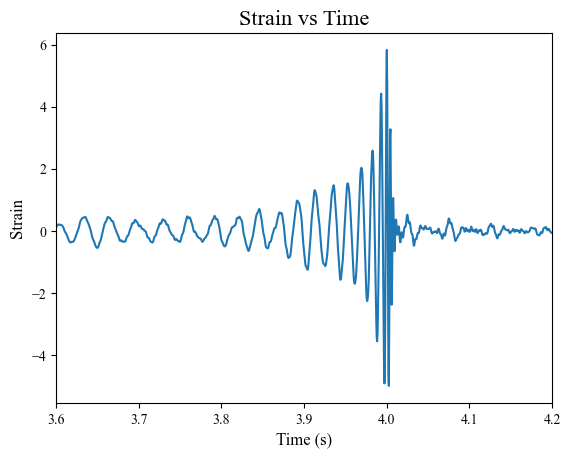

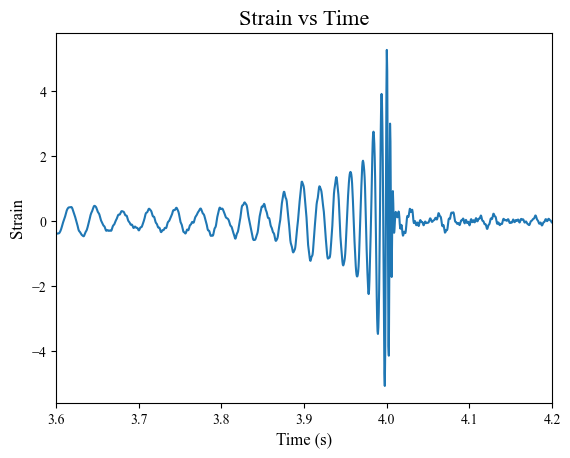

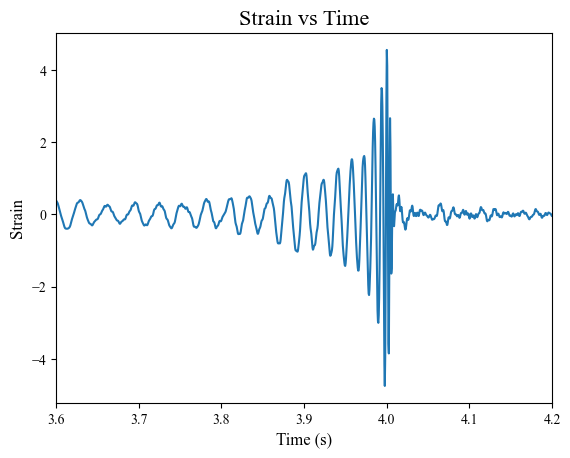

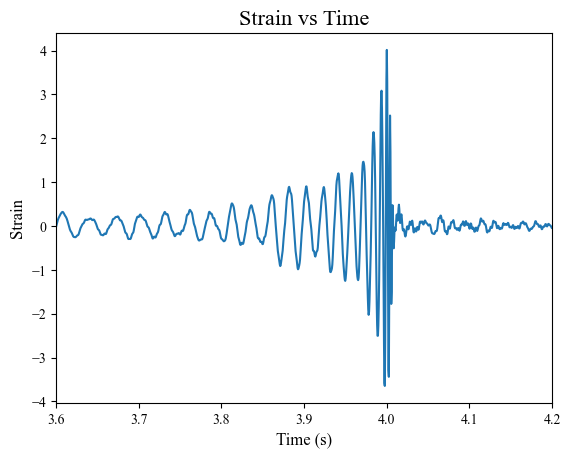

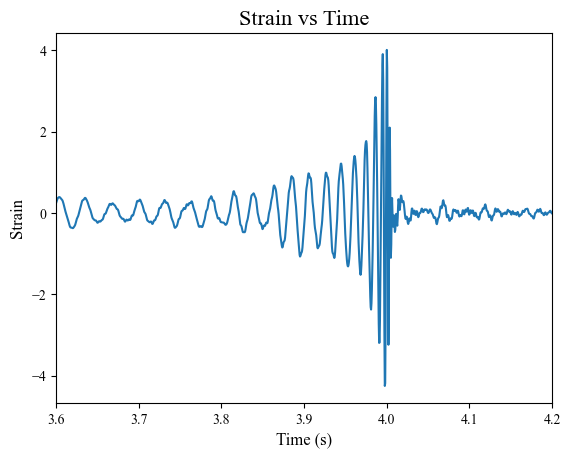

In [11]:
mass_one = [37,38,36,35,34,33,32,31,25]
mass_two = [24,23,22,21,20,19,18,17,24]
mass_three = np.array(mass_one) - 1
distance = [400,500,350,450,430,510,390,200,420]
distance = np.sort(np.array(distance))
plt.figure()
for i in range(len(mass_one)):
        t, template = gw.make_template(mass_one[i],mass_two[i],2048,8,inv_psd,distance[i])
        plt.plot(t, template)
        plt.xlabel('Time (s)', fontsize=axis_size)
        plt.xlim(3.6,4.2)
        plt.ylabel('Strain', fontsize=axis_size)
        plt.title('Strain vs Time', fontsize=title_size)
        plt.show()





For greater total mass pairs (m1+m2) the amplitude of the merger is greater around the time of coalescence and the build up is quicker.

## Detecting the signals for the 10 Black hole mergers

### Finding the SNR and component masses for 1 signal

In this task to obtain the SNR of the signal the function gw.get_snr was used (as supplied by the lalsuite package) which takes in three parameters, the strain data, the template data as obtained from the make_template function and the sampling frequency of the detector. This returns the SNR timeseries and where the peak is located is equivalent to the time of the merger.  

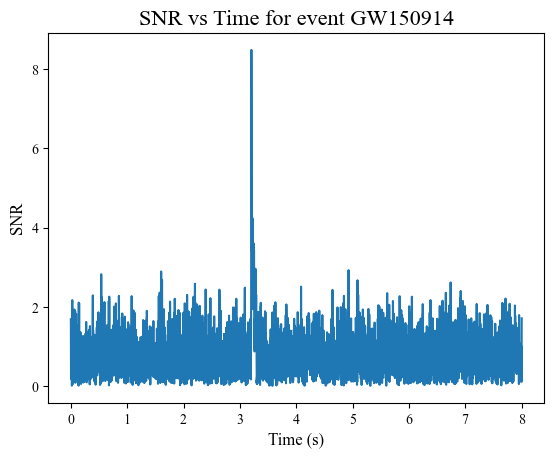

In [12]:
snr_ts = gw.get_snr(strain, template, 2048)
plt.figure()
plt.plot(time,snr_ts)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('SNR', fontsize=axis_size)
plt.title('SNR vs Time for event GW150914', fontsize=title_size)
plt.show()

min_time = time[np.where(np.max(snr_ts) == snr_ts)]-0.05
max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.05


For the first data set (GW150914) the SNR of the merge is greater then that for the other data sets as will be apparent below. Due to this the signal was easier to detect and is the reason why this was the first gravitational wave to be detected.

### Determining the best fit masses and thus distances for the first signal GW150914

In this task the masses are assumed to fit the following requirements: m1 > m2 and m1/m2 < 8. Then two for loops have been used to iterate over the mass pairs in the range of 2 to 80 solar masses (with 20 test masses for each), the SNR is calculated for each pair and saved to an array and the maximum value is found and the index of this value is used to find the corresponding mass pair. Using this data a colour map plot can be made to show the masses for each mass pair and how the SNR changes with these values. This step is then repeated for the same data but with a smaller range of possible mass pairs to get a more accurate plot around the best fit mass pair.

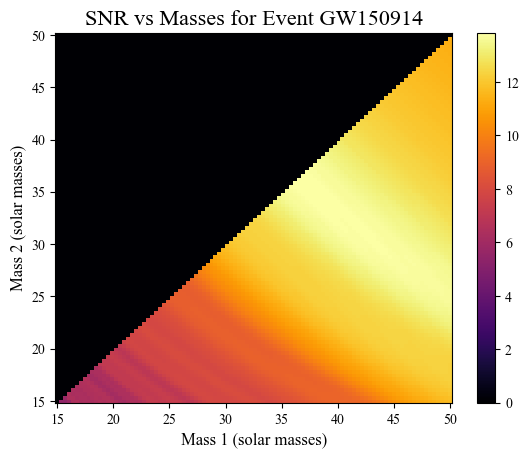

From the graphs and calculations to find the best mass pairs the best mass pair for the GW150914 event is 36.21 and 35.86 (solar masses) with a snr of 13.83


In [13]:
masses = np.linspace(2,80,20)
currentmax = 0
mass1 = [] 
mass2 = [] 
allsnr = []

for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr.append(0)

reshaped = (np.reshape(allsnr, (20,20)).T)

allsnr2 = []
currentmax = 0
masses2 = np.linspace(15,50,100)
maxsnr = []
for m1 in masses2:
    for m2 in masses2:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr2.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr2.append(0)

reshaped2 = (np.reshape(allsnr2, (100,100)).T)

plt.figure()
# plt.subplot(1,2,1)
# plt.suptitle('GW150914', fontsize=all_title)
# plt.pcolor(masses, masses, reshaped)
# plt.colorbar()
# plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
# plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
# plt.title('SNR vs Masses', fontsize=title_size)
# plt.subplot(1,2,2)
plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
plt.title('SNR vs Masses for Event GW150914', fontsize=title_size)
plt.pcolor(masses2, masses2, reshaped2, cmap='inferno')
plt.colorbar()
plt.show()
print(f'From the graphs and calculations to find the best mass pairs the best mass pair for the GW150914 event is {M1:2.2f} and {M2:2.2f} (solar masses) with a snr of {currentmax:2.2f}')

Now that the best fit mass pair has been found the distance to the source can be calculated using the template, SNR and best fit mass pair, this is then passed as the arguments to the make_signal function and with estimated parameter for the distance, time and phase of coalescence scipy's curve_fit can be used to find the best fit values for these parameters.
This template can then be plotted against the original data to observe the wellness of the fit
<br>
If the SNR value in the timeseries is not a good match to the raw data it appears difficult to distinguish from the noise in the background, this would result in poor fits for all the values calculated after.

The best fit parameters for distance, time, and phase are 1133.58 ± 82.23 Mpc, 3.198 ± 0.000 s, and 0.000 ± 0.157 radians respectively.


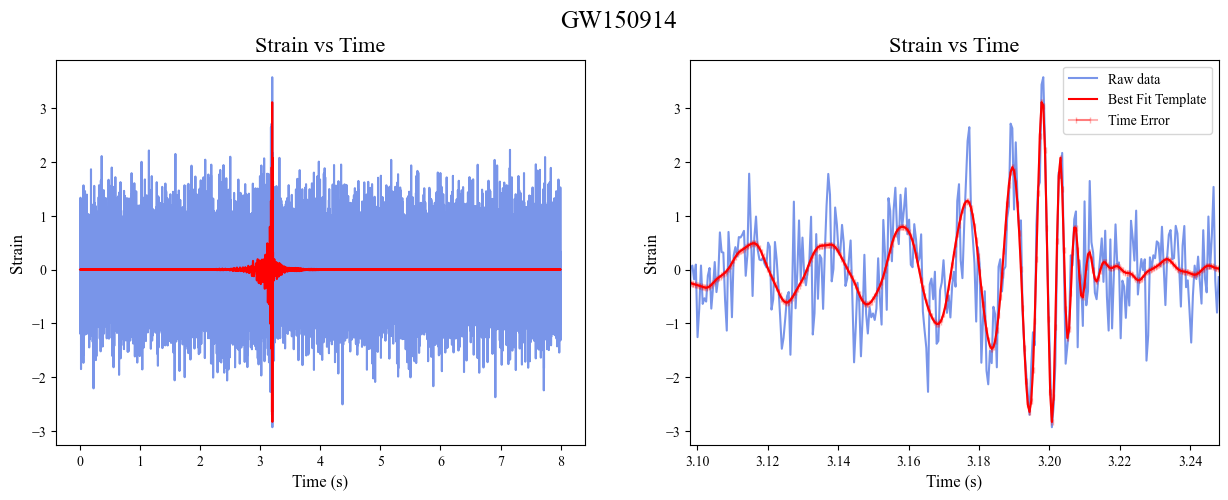

In [14]:
mass1 = M1
mass2 = M2
m1 = M1
m2 = M2
t, template = gw.make_template(m1,m2,2048,8,inv_psd)
snr_ts = gw.get_snr(strain,template,2048)

def make_signal(t,d,tc,phic):
    _,signal = gw.make_template(mass1,mass2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
    return signal

t = 8
tc_min = min_time
tc_max = max_time
phic_min = 0
phic_max = 2*np.pi
d_min = 0
d_max = 10000
p0 = np.array([1000,time[(np.where(np.max(snr_ts) == snr_ts),)],0.5], dtype = object)
ht_err = np.array(np.ones(strain.size))
b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
popt, pcov = curve_fit(make_signal,time ,strain, p0 = np.array([1000,time[(np.where(np.max(snr_ts) == snr_ts),)],0.5], dtype = object),bounds = b, sigma=ht_err, absolute_sigma=True)
t, template = gw.make_template(m1,m2,2048,8,inv_psd,d = popt[0],tc = popt[1],phic = popt[2])

err = np.sqrt(np.diag(pcov))

print(f'The best fit parameters for distance, time, and phase are {popt[0]:2.2f} ± {err[0]:2.2f} Mpc, {popt[1]:4.4g} ± {err[1]:4.3f} s, and {popt[2]:3.3f} ± {err[2]:3.3f} radians respectively.')
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.suptitle('GW150914', fontsize=all_title)
plt.plot(time, strain, color = 'royalblue', alpha = 0.7)
plt.plot(t, template, color = 'red')
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.subplot(1,2,2)
plt.plot(time, strain,color = 'royalblue', alpha = 0.7, label = 'Raw data')
plt.plot(t, template, color = 'red', label = 'Best Fit Template')
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(popt[1]-0.1,popt[1]+0.05)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.errorbar(t,template, xerr = err[1],color = 'red',capsize = 2, alpha = 0.3, label = 'Time Error')
plt.legend()
plt.show()

The distance to the source calculated from this method is off by around a factor of 2-3 from the true distance as published by the LIGO research group. This is potentially due to the fact that this method as described above may not take into account all the noise reduction techniques that were used in the actual detection, but also here the inclination angle of the event has not been taken into consideration, and this may have a large effect on this value.


### Determining the best fit masses and thus distances for the other signals

For the next task the above steps to find the best fit masses and estimates on the distance, time, and phase of coalescence were repeated for all the signals by use of a for loop to iterate over the data sets and an if statement to skip the data set that corresponds to event GW170817 as this is a neutron star merger and not a binary black hole merger.

The colour plot for the mass pairs against the SNR, and the template data for the event as predicted by the best fit parameters against the raw data. And finally these best fit parameters are printed for each event along with the associated errors as calculated by the coariance matrix output from scipy's curve_fit.


--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW150914
The best fit masses for GW150914 are 37.37 and 34.21 (In units of solar masses).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


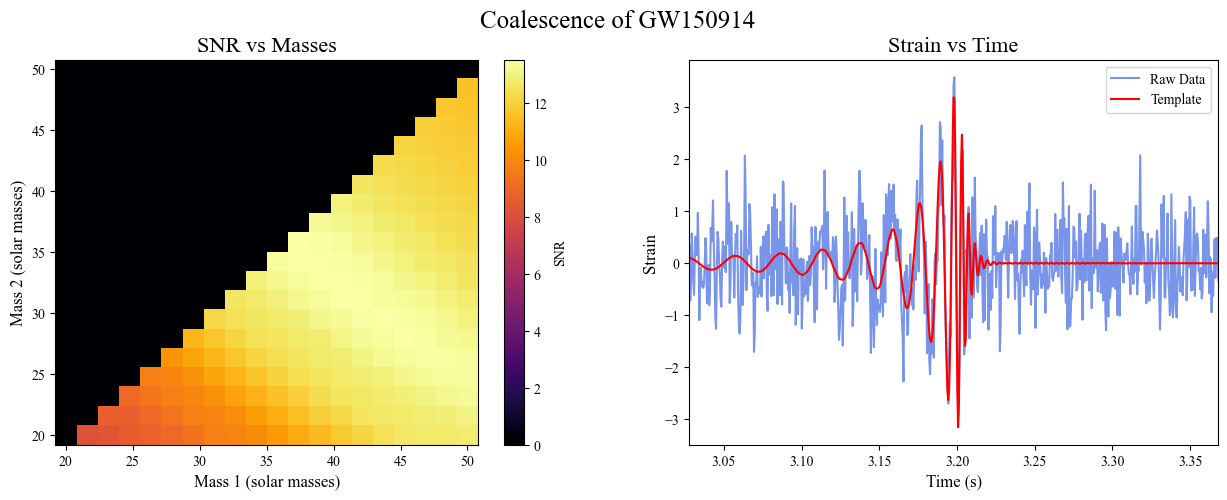

The best fit parameters for merger GW150914 for distance, time, and phase are 1124.38 ± 81.52 Mpc, 3.19782 ± 0.00019 s, and 0.2617 ± 0.1563 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW151012
The best fit masses for GW151012 are 38.16 and 10.53 (In units of solar masses).


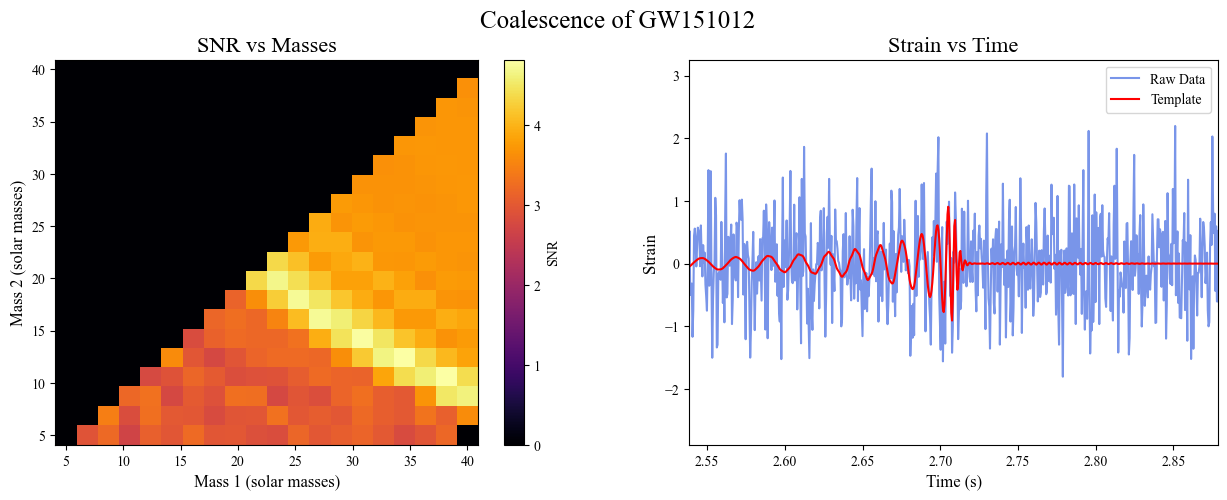

The best fit parameters for merger GW151012 for distance, time, and phase are 1767.06 ± 386.62 Mpc, 2.70757 ± 0.00051 s, and 9.436e-13 ± 0.409 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW151226
The best fit masses for GW151226 are 12.84 and 9.26 (In units of solar masses).


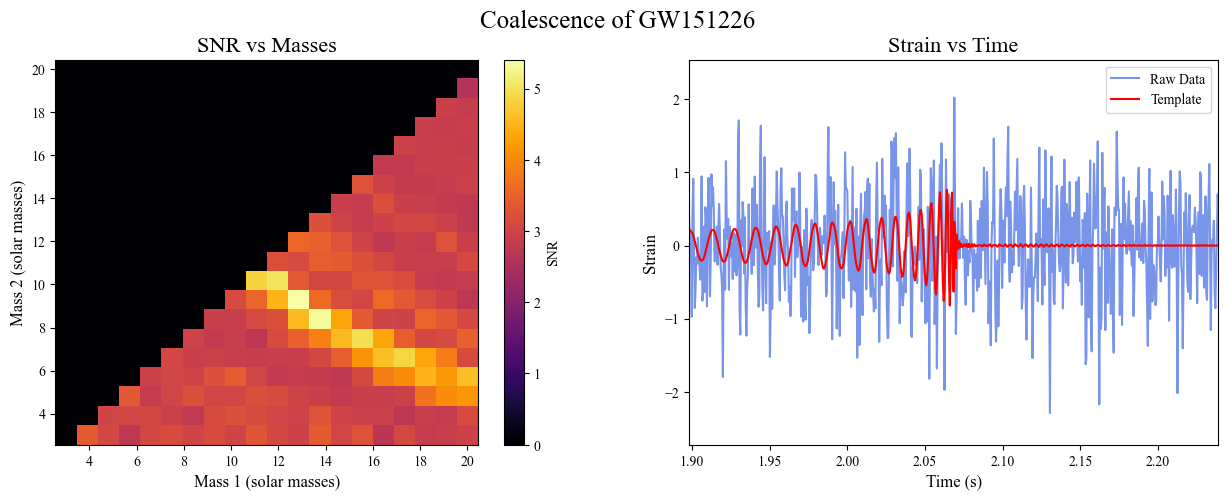

The best fit parameters for merger GW151226 for distance, time, and phase are 1014.39 ± 172.85 Mpc, 2.06844 ± 0.00026 s, and 2.808 ± 0.2582 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170104
The best fit masses for GW170104 are 39.47 and 22.63 (In units of solar masses).


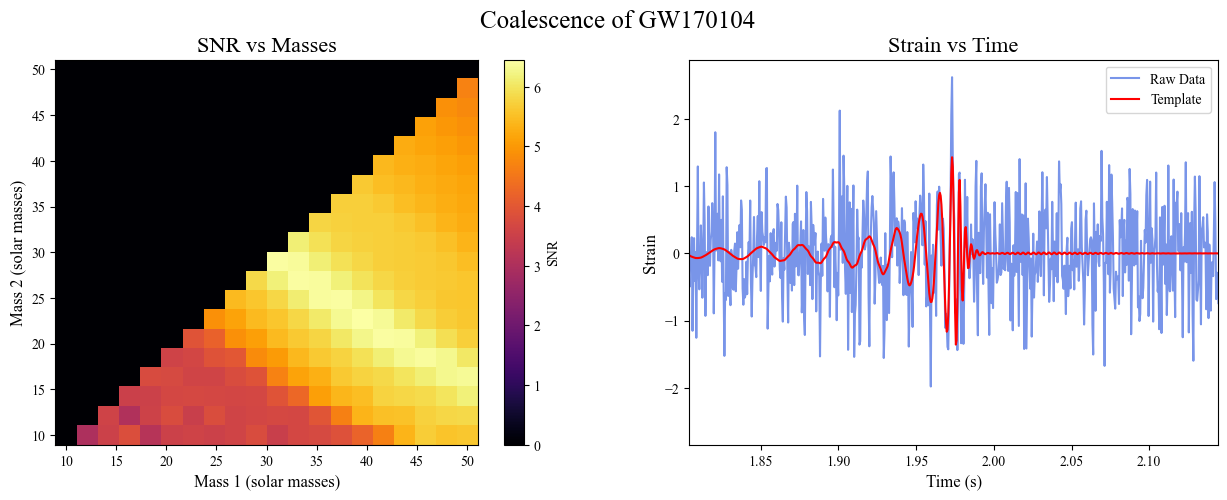

The best fit parameters for merger GW170104 for distance, time, and phase are 2061.60 ± 331.22 Mpc, 1.97423 ± 0.00038 s, and 2.109 ± 0.3256 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170608
The best fit masses for GW170608 are 12.42 and 7.68 (In units of solar masses).


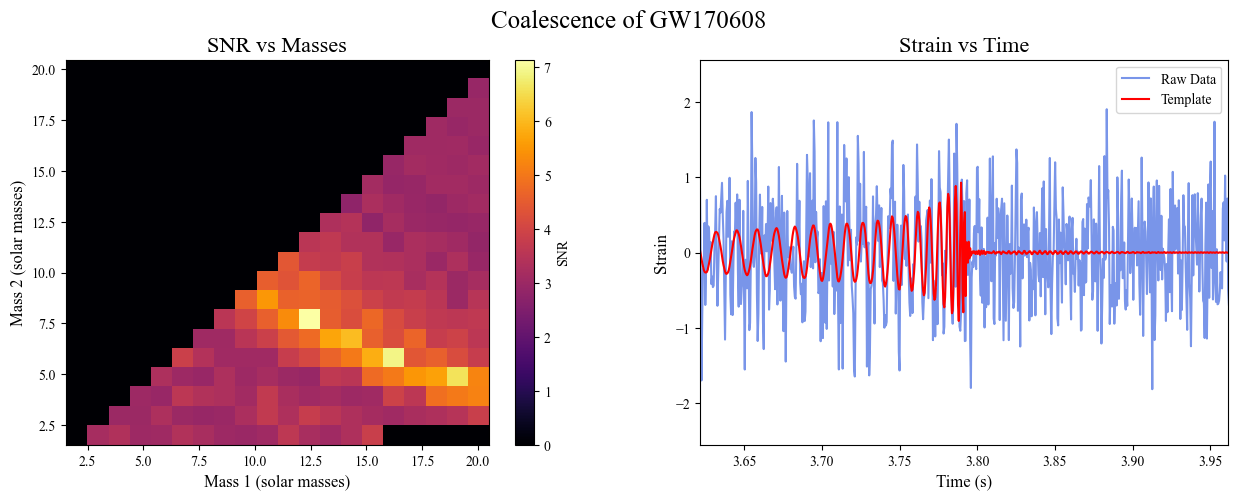

The best fit parameters for merger GW170608 for distance, time, and phase are 734.49 ± 99.24 Mpc, 3.79138 ± 0.00021 s, and 1.801 ± 0.2037 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170729
The best fit masses for GW170729 are 73.68 and 32.63 (In units of solar masses).


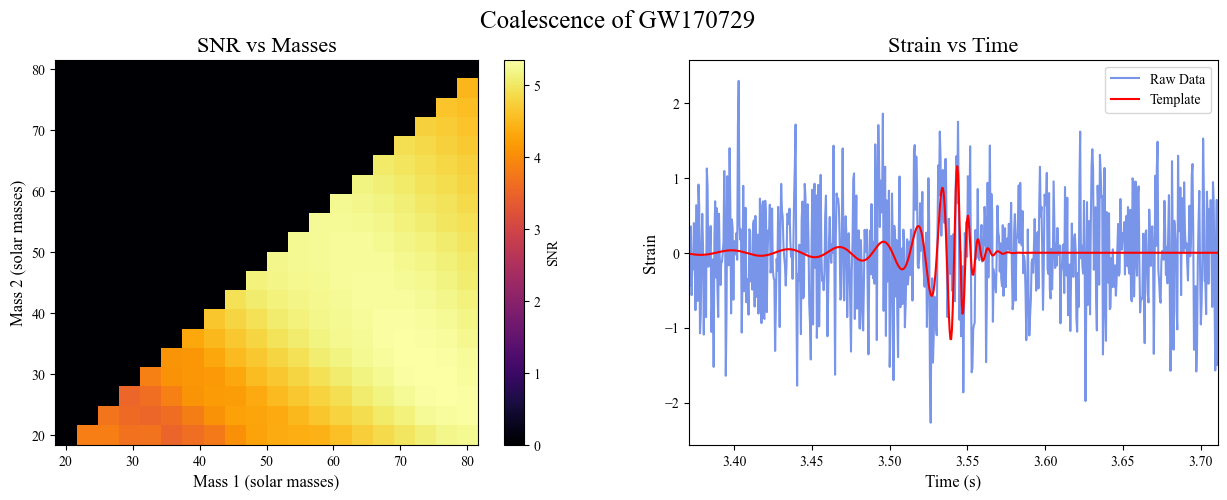

The best fit parameters for merger GW170729 for distance, time, and phase are 3359.43 ± 630.78 Mpc, 3.54093 ± 0.00081 s, and 2.149 ± 0.5169 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170809
The best fit masses for GW170809 are 44.47 and 15.53 (In units of solar masses).


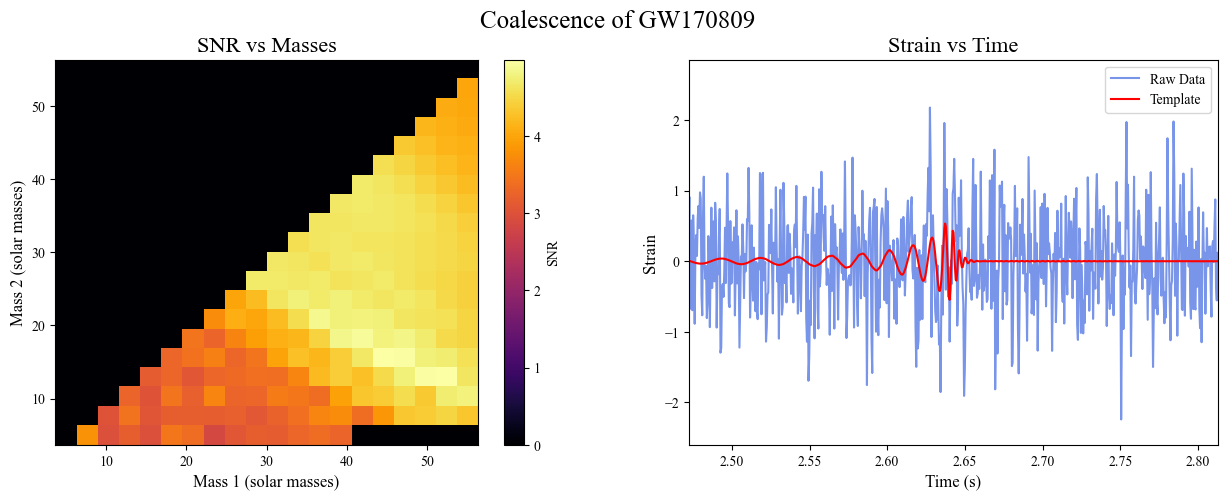

The best fit parameters for merger GW170809 for distance, time, and phase are 4187.51 ± 1669.46 Mpc, 2.64019 ± 0.00099 s, and 8.393e-10 ± 0.8004 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170814
The best fit masses for GW170814 are 31.58 and 27.89 (In units of solar masses).


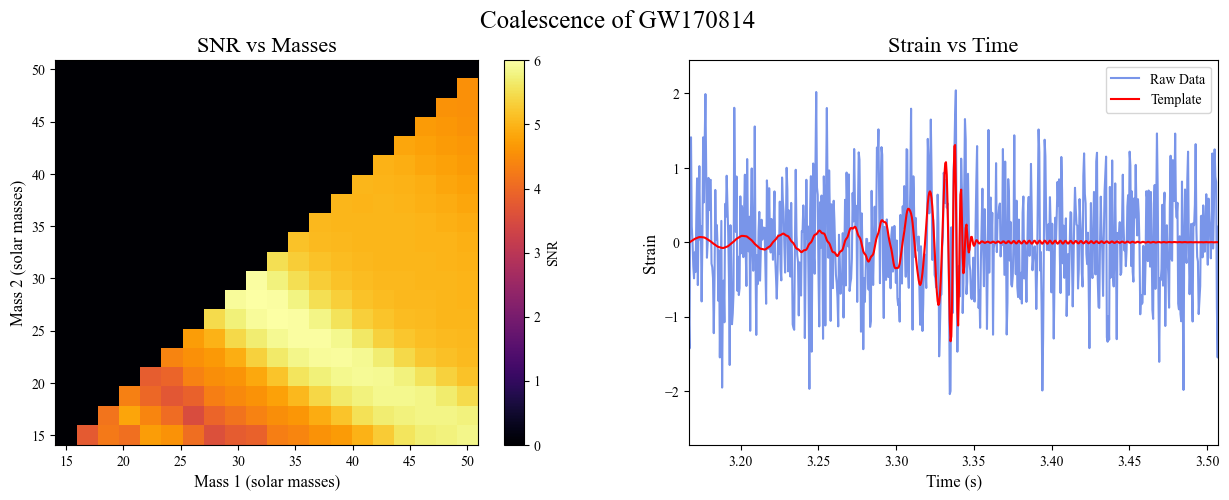

The best fit parameters for merger GW170814 for distance, time, and phase are 2227.32 ± 375.95 Mpc, 3.33708 ± 0.00038 s, and 0.5982 ± 0.3347 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170817
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170818
The best fit masses for GW170818 are 33.00 and 12.00 (In units of solar masses).


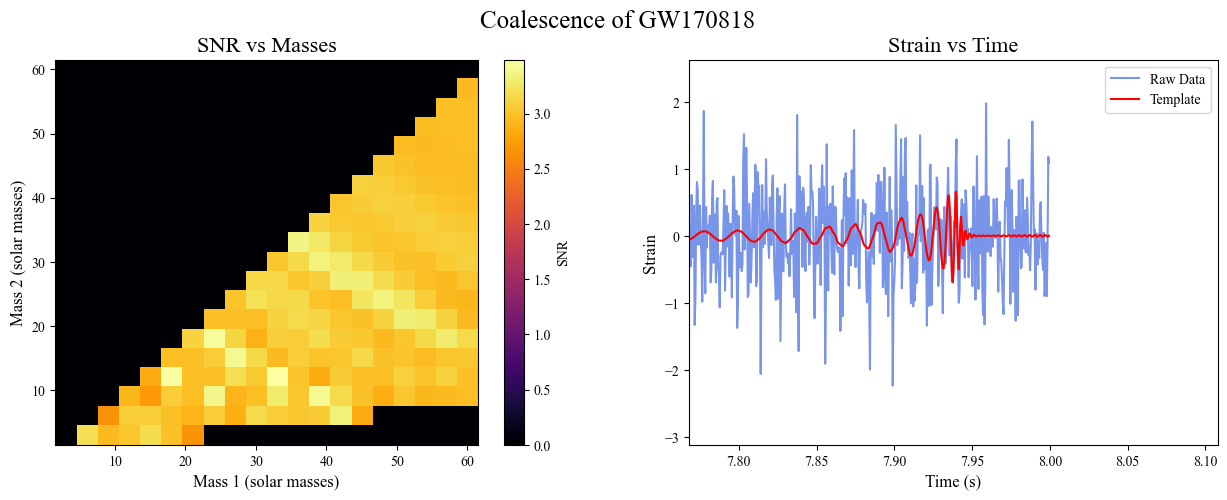

The best fit parameters for merger GW170818 for distance, time, and phase are 2503.67 ± 733.24 Mpc, 7.93808 ± 0.00064 s, and 2.667 ± 0.533 radians respectively.
--------------------------------------------------------------------------------------------------
The Binary Black Hole merger event GW170823
The best fit masses for GW170823 are 57.89 and 24.74 (In units of solar masses).


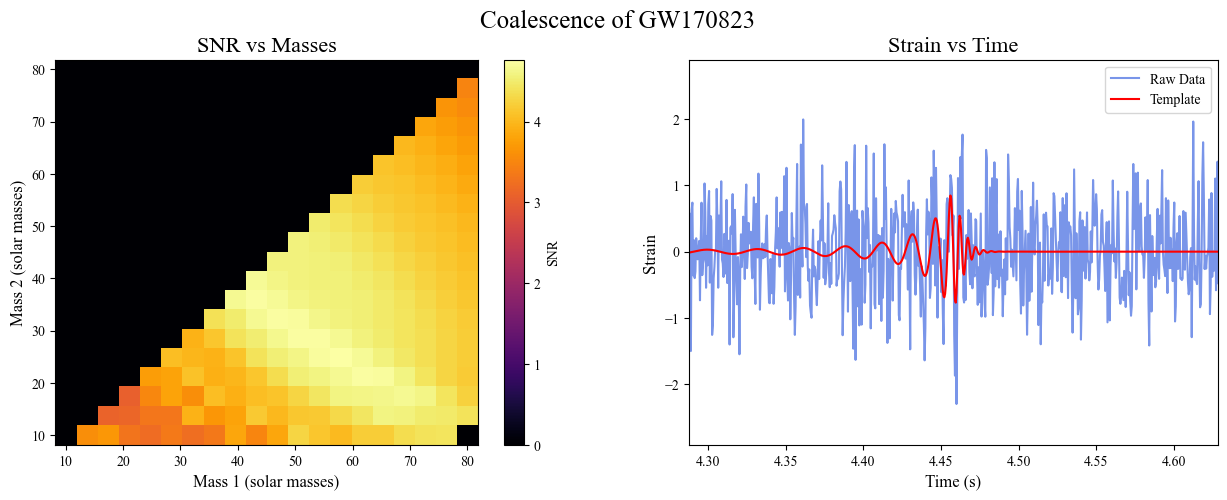

The best fit parameters for merger GW170823 for distance, time, and phase are 3970.50 ± 1079.22 Mpc, 4.45614 ± 0.00089 s, and 1.379e-10 ± 0.6436 radians respectively.


In [15]:
path = 'strain_data/'
files = np.sort(os.listdir(path))

distance_coel = [] 
time_coel = []
phase_coel = [] 
larger_masses = []
smaller_masses = []
names = []
dist_err = []
time_err = []
phase_err = []

i = 0
j = 0

for file in files:
    filename = path+file
    print('--------------------------------------------------------------------------------------------------')
    print(f'The Binary Black Hole merger event {file.replace("_strain.txt","")}')
    if file.startswith('GW170817'):
        pass
    else:
        names.append(file)
        if file.endswith('strain.txt'):
            data = np.loadtxt(filename)
            time = data[:,0]
            strain = data[:,1] 
        for data in os.listdir('inv_psd/'):
            if data.endswith('inv_psd.txt'):
                inv_psd_data = np.loadtxt('inv_psd/'+ data)
                inv_psd2 = inv_psd_data[:,1]
        t, template = gw.make_template(37,36,2048,8,inv_psd2,400)
        snr_ts = gw.get_snr(strain, template, 2048)
        min_time = time[np.where(np.max(snr_ts) == snr_ts)]-0.05
        max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.05

        masses = np.linspace(2,80,10)
        currentmax = 0
        mass1 = [] 
        mass2 = [] 
        allsnr = []

        for m1 in masses:
            for m2 in masses:
                if m1>m2 and (m1/m2) < 8:
                    t, template = gw.make_template(m1,m2,2048,8,inv_psd2)
                    snr_ts = gw.get_snr(strain, template, 2048)
                    maxsnr = np.max(snr_ts)
                    allsnr.append(maxsnr)
                    if maxsnr > currentmax:
                        currentmax = maxsnr
                        M1 = m1
                        M2 = m2
                else:
                    allsnr.append(0)
        reshaped = (np.reshape(allsnr, (10,10)).T)

        set_mass1 = [50, 40, 20, 50, 20, 80, 55, 50, 60, 80]
        set_mass2 = [20, 5, 3, 10, 2, 20, 5, 15, 3, 10]
        masses2 = []
        masses2 = np.linspace(set_mass1[i],set_mass2[j],20)
        i = i + 1
        j = j + 1
        allsnr2 = []
        currentmax = 0

        maxsnr = []
        for m1 in masses2:
            for m2 in masses2:
                if m1>m2 and (m1/m2) < 8:
                    t, template = gw.make_template(m1,m2,2048,8,inv_psd2,400)
                    snr_ts = gw.get_snr(strain, template, 2048)
                    maxsnr = np.max(snr_ts)
                    allsnr2.append(maxsnr)
                    if maxsnr > currentmax:
                        currentmax = maxsnr
                        M1 = m1
                        M2 = m2
                else:
                    allsnr2.append(0)
        reshaped = (np.reshape(allsnr2, (20,20)).T)

        mass1 = M1
        mass2 = M2
        m1 = M1
        m2 = M2
        t, template = gw.make_template(m1,m2,2048,8,inv_psd2)

        snr_ts = gw.get_snr(strain, template, 2048)
        min_time = time[np.where(np.max(snr_ts) == snr_ts)]-0.05
        max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.05
        snr_ts = gw.get_snr(strain,template,2048)

        def make_signal(t,d,tc,phic):
            _,signal = gw.make_template(M1,M2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
            return signal

        t = 8
        distances = np.array(np.linspace(100,10000,10000))
        tc_min = min_time
        tc_max = max_time
        phic_min = 0
        phic_max = 2*np.pi
        d_min = 100
        d_max = 4500

        print(f'The best fit masses for {file.replace("_strain.txt","")} are {M1:2.2f} and {M2:2.2f} (In units of solar masses).')

        ht_err = np.array(np.ones(strain.size))
        b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
        t_est = time[np.argmax(snr_ts)]
        p0 = [1000,t_est,0.5]
        popt, pcov = curve_fit(make_signal,time ,strain, p0 = [1000,time[(np.where(np.max(snr_ts) == snr_ts),)],0.5],bounds = b, sigma=ht_err, absolute_sigma=True)
        err = np.sqrt(np.diag(pcov))

        distance_coel.append(popt[0])
        time_coel.append(popt[1])
        phase_coel.append(popt[2])
        larger_masses.append(M1)
        smaller_masses.append(M2)
        dist_err.append(err[0])
        time_err.append(err[1])
        phase_err.append(err[2])


        t, template = gw.make_template(m1,m2,2048,8,inv_psd2,d = popt[0],tc = popt[1],phic = popt[2])
        lims = [tc_min-0.12, tc_max+0.12]

        plt.figure(figsize=(15,5))
        plt.suptitle(f'Coalescence of {file.replace("_strain.txt","")}', fontsize=all_title)
        plt.subplot(1,2,1)
        plt.title('SNR vs Masses', fontsize=title_size)
        plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
        plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
        plt.pcolor(masses2, masses2, reshaped, cmap='inferno')
        plt.colorbar(label='SNR')


        plt.subplot(1,2,2)
        plt.plot(time, strain, label='Raw Data',color = 'royalblue', alpha = 0.7)
        plt.plot(t, template, label='Template', color = 'red')
        plt.xlabel('Time (s)', fontsize=axis_size)
        plt.xlim(lims[0], lims[1])
        plt.ylabel('Strain', fontsize=axis_size)
        plt.title('Strain vs Time', fontsize=title_size)
        plt.legend()
        plt.show()

        print(f'The best fit parameters for merger {file.replace("_strain.txt","")} for distance, time, and phase are {popt[0]:3.2f} ± {err[0]:3.2f} Mpc, {popt[1]:4.5f} ± {err[1]:4.5f} s, and {popt[2]:4.4g} ± {err[2]:4.4g} radians respectively.')



The results from each event were saved to arrays and then rounded to the most relevant decimal place for each value before being printed in a dataframe for easy comparison along with their errors. (Once again the distance measurements for all the data sets are off by a factor of 2-3 and this is the same as discussed above).

In [16]:
distance_coel = np.round(distance_coel,2)
dist_err = np.round(dist_err,2)
time_coel = np.round(time_coel,3)
time_err = np.round(time_err,3)
phase_coel = np.round(phase_coel,2)
phase_err = np.round(phase_err,2)
larger_masses = np.round(larger_masses,2)
smaller_masses = np.round(smaller_masses,2)

df = pd.DataFrame({'file':names,'Distance (Mpc)':distance_coel, 'Distance Error (±)':dist_err, 'Time (s)':time_coel, 'Time Error (±):':time_err, 'Phase (radians)':phase_coel,'Phasee Error (±)':phase_err, 'Larger Mass (solar masses)':larger_masses, 'Smaller Mass (solar masses)':smaller_masses})
df

,file,Distance (Mpc),Distance Error (±),Time (s),Time Error (±):,Phase (radians),Phasee Error (±),Larger Mass (solar masses),Smaller Mass (solar masses)
0,GW150914_strain.txt,1124.38,81.52,3.198,0.000,0.26,0.16,37.37,34.21
1,GW151012_strain.txt,1767.06,386.62,2.708,0.001,0.00,0.41,38.16,10.53
2,GW151226_strain.txt,1014.39,172.85,2.068,0.000,2.81,0.26,12.84,9.26
3,GW170104_strain.txt,2061.60,331.22,1.974,0.000,2.11,0.33,39.47,22.63
4,GW170608_strain.txt,734.49,99.24,3.791,0.000,1.80,0.20,12.42,7.68
5,GW170729_strain.txt,3359.43,630.78,3.541,0.001,2.15,0.52,73.68,32.63
6,GW170809_strain.txt,4187.51,1669.46,2.640,0.001,0.00,0.80,44.47,15.53
7,GW170814_strain.txt,2227.32,375.95,3.337,0.000,0.60,0.33,31.58,27.89
8,GW170818_strain.txt,2503.67,733.24,7.938,0.001,2.67,0.53,33.00,12.00
9,GW170823_strain.txt,3970.50,1079.22,4.456,0.001,0.00,0.64,57.89,24.74


### Analysis for the Neutron star merger GW170817

For this the same steps as above were followed but this time using the data for the neutron star merger GW170817. However fo the Neutron star merger the time of the signal was not clear as the signal is not as strong due to the relative lightness of the merger event. And because of this uncertainty the values obtained for the distance and time of coalescence are not as accurate as for the binary blcak hole mergers.

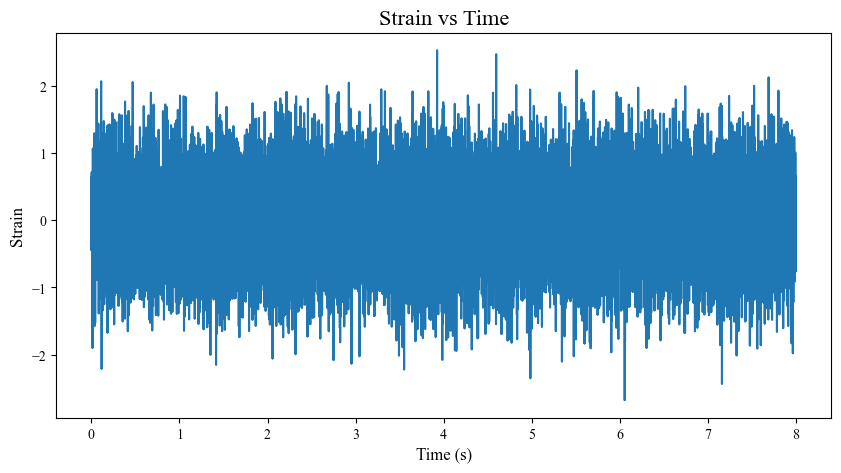

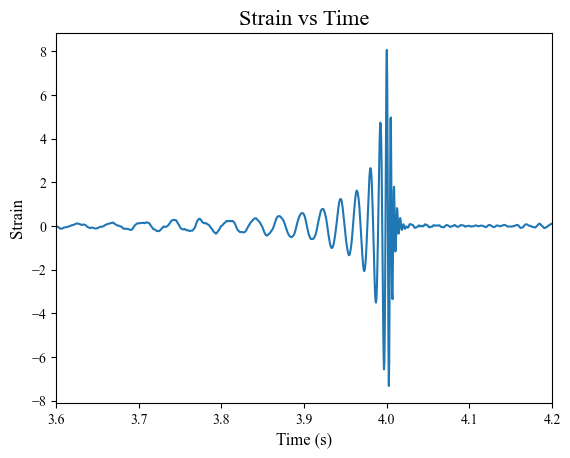

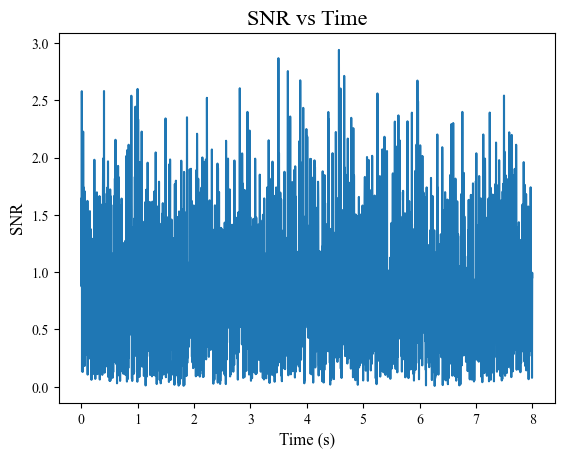

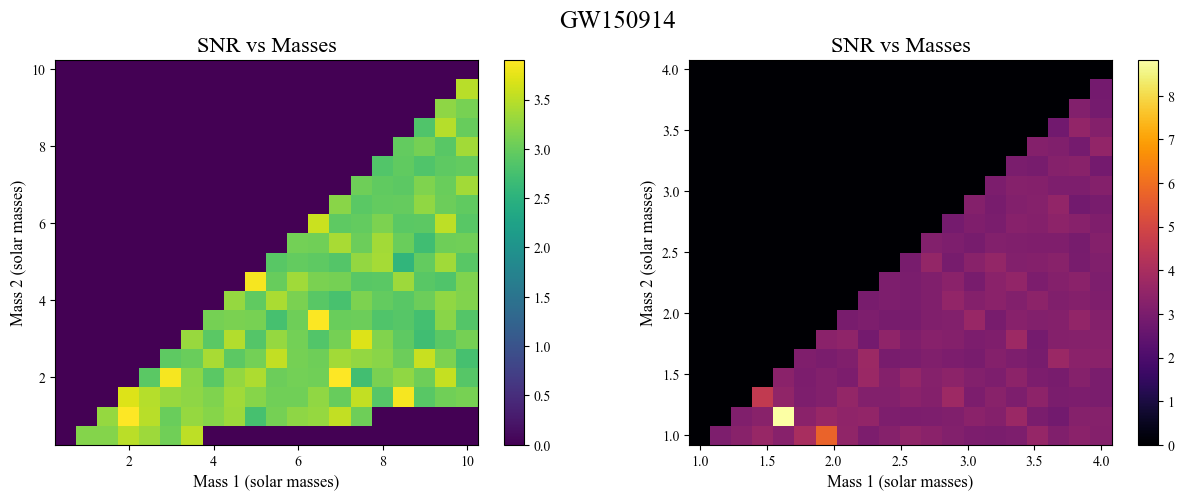

From the graphs and calculations to find the best mass pairs the best mass pair for the GW170817 event is 1.63 and 1.16 (solar masses) with a snr of 8.83


In [17]:
data = np.loadtxt('strain_data/GW170817_strain.txt')
time = data[:,0]
strain = data[:,1]

plt.figure(figsize = (10,11))
plt.subplot(2,1,1)
plt.plot(time, strain)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.show()

inv_psd = np.loadtxt('inv_psd/GW170817_inv_psd.txt',usecols=(1,))
t, template = gw.make_template(36,31,2048,8,inv_psd,400)

plt.figure()
plt.plot(t, template)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(3.6,4.2)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.show()

snr_ts = gw.get_snr(strain, template, 2048)
plt.figure()
plt.plot(time,snr_ts)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('SNR', fontsize=axis_size)
plt.title('SNR vs Time', fontsize=title_size)
plt.show()

min_time = time[np.where(np.max(snr_ts) == snr_ts)]-0.05
max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.05

masses = np.linspace(0.5,10,20)
currentmax = 0
mass1 = [] 
mass2 = [] 
allsnr = []

for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr.append(0)

reshaped = (np.reshape(allsnr, (20,20)).T)

allsnr2 = []
currentmax = 0
masses2 = np.linspace(1,4,20)
maxsnr = []
for m1 in masses2:
    for m2 in masses2:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr2.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr2.append(0)

reshaped2 = (np.reshape(allsnr2, (20,20)).T)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.suptitle('GW150914', fontsize=all_title)
plt.pcolor(masses, masses, reshaped)
plt.colorbar()
plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
plt.title('SNR vs Masses', fontsize=title_size)
plt.subplot(1,2,2)
plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
plt.title('SNR vs Masses', fontsize=title_size)
plt.pcolor(masses2, masses2, reshaped2, cmap='inferno')
plt.colorbar()
plt.show()
print(f'From the graphs and calculations to find the best mass pairs the best mass pair for the GW170817 event is {M1:2.2f} and {M2:2.2f} (solar masses) with a snr of {currentmax:2.2f}')

In [18]:

mass1 = M1
mass2 = M2
m1 = M1
m2 = M2
t, template = gw.make_template(m1,m2,2048,8,inv_psd)

snr_ts = gw.get_snr(strain, template, 2048)
min_time = time[np.where(np.max(snr_ts) == snr_ts)]-0.05
max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.05
snr_ts = gw.get_snr(strain,template,2048)

def make_signal(t,d,tc,phic):
    _,signal = gw.make_template(M1,M2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
    return signal

t = 8
distances = np.array(np.linspace(100,10000,10000))
tc_min = min_time
tc_max = max_time
phic_min = 0
phic_max = 2*np.pi
d_min = 10
d_max = 1000

print(f'The best fit masses for {file.replace("_strain.txt","")} are {M1:2.2f} and {M2:2.2f} (In units of solar masses).')

ht_err = np.array(np.ones(strain.size))
b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
t_est = time[np.argmax(snr_ts)]
p0 = [1000,t_est,0.5]
popt, pcov = curve_fit(make_signal,time ,strain, p0 = [1000,time[(np.where(np.max(snr_ts) == snr_ts),)],0.5],bounds = b, sigma=ht_err, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))

# distance_coel.append(popt[0])
# time_coel.append(popt[1])
# phase_coel.append(popt[2])
# larger_masses.append(M1)
# smaller_masses.append(M2)
# dist_err.append(err[0])
# time_err.append(err[1])
# phase_err.append(err[2])


t, template = gw.make_template(m1,m2,2048,8,inv_psd,d = popt[0],tc = popt[1],phic = popt[2])
lims = [tc_min-0.12, tc_max+0.12]

plt.figure(figsize=(15,5))
plt.suptitle(f'Coalescence of {file.replace("_strain.txt","")}', fontsize=all_title)
plt.subplot(1,2,1)
plt.title('SNR vs Masses', fontsize=title_size)
plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
plt.pcolor(masses2, masses2, reshaped, cmap='inferno')
plt.colorbar(label='SNR')


plt.subplot(1,2,2)
plt.plot(time, strain, label='Raw Data',color = 'royalblue', alpha = 0.7)
plt.plot(t, template, label='Template', color = 'red')
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(lims[0], lims[1])
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.legend()
plt.show()

print(f'The best fit parameters for merger {file.replace("_strain.txt","")} for distance, time, and phase are {popt[0]:3.2f} ± {err[0]:3.2f} Mpc, {popt[1]:4.5f} ± {err[1]:4.5f} s, and {popt[2]:4.4g} ± {err[2]:4.4g} radians respectively.')



The best fit masses for GW170823 are 1.63 and 1.16 (In units of solar masses).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

## Properties of the population

### Frequency of masses for all the events

For the frequency of the masses for all events it is evident that the most common region is around the 30-40 solar masses with the lowest mass being 8.4 solar masses and the largest being 76 solar masses.
Masses lower then 8.4 solar masses have not been detected as this is on the border that a star needs to collapse into a black hole as opposed to a neutron star. and masses greater then 75 solar masses have not been detected as this is the upper limit of the mass of a black hole that can be formed in a binary system.


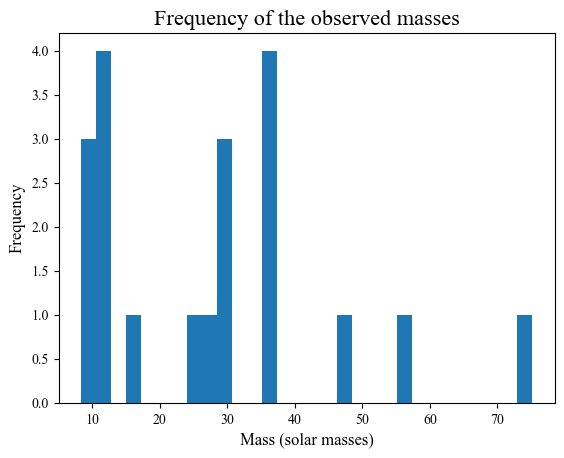

In [ ]:
all_masses = np.array(larger_masses)
all_masses = np.append(all_masses, smaller_masses)
sum_of_masses = np.array(larger_masses) + np.array(smaller_masses)
sort_all_masses = np.sort(all_masses)

plt.figure()
plt.hist(all_masses, bins=30)
plt.xlabel('Mass (solar masses)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Frequency of the observed masses', fontsize=title_size)
plt.show()




### Frequency of binary black hole pairs for the distance range

The closest observed binary black hole merger was GW170608 at a distance of 664 Mpc and the furthest was GW170823 at a distance of 4111 Mpc. Merger events that are closer to earth are not detected, this may be due to the fact that for a binary black hole pair to exist there has to be a region of high matter density, and this is not likely to be found in the centre of our galaxy and thus the mergers are most likely present in other galaxies. The reason why mergers have not been detected at distances greater then 4111 Mpc is propbably because for the average mass pair found in this analysis of around 30-40 solar masses the signal to noise ratio would not be high enough to resolve the signal.

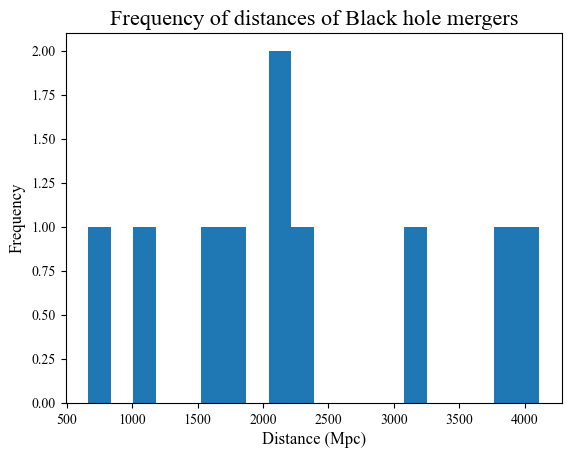

In [ ]:
plt.figure()
plt.hist(distance_coel, bins=20)
plt.xlabel('Distance (Mpc)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Frequency of distances of Black hole mergers', fontsize=title_size)
plt.show()



### Total binary black hole mass distribution for the distance range

The plot of the total mass against the distance is shown below, from this it can be seen that the total mass of the binary black hole pairs is linearly proportional to the distance to the source. This is due to the fact that for short distances the detected mass pairs are more likely to be smaller masses as these signals have a higher SNR and are easier to detect, and for larger distances smaller masses wouldn't be detected as the SNR would be too low. Therefore for greater distances the mass pairs are more likely to be larger masses.

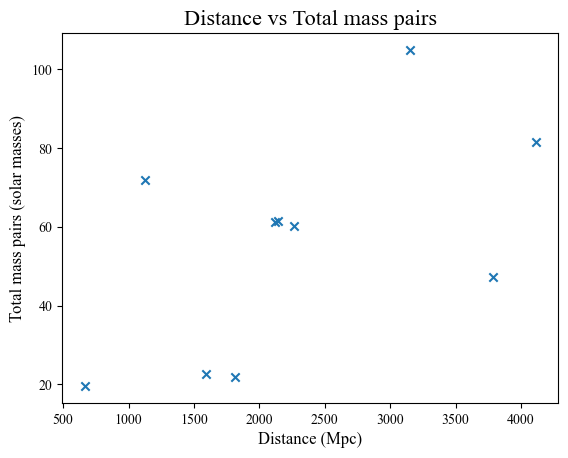

In [ ]:
plt.figure()
plt.scatter(distance_coel,sum_of_masses, marker = 'x')
plt.xlabel('Distance (Mpc)', fontsize=axis_size)
plt.ylabel('Total mass pairs (solar masses)', fontsize=axis_size)
plt.title('Distance vs Total mass pairs', fontsize=title_size)
plt.show()


For this experiment the results obtained as shown in the table above and along with their corresponding uncertainties, were shown to be in agreement with the results obtained by the LIGO research group. This is a good indication that the overall method of this lab was correct and the results are accurate. The errors calculated on these results also show a high confidence in the results obtained as the errors are small compared to the values themselves, these errors are most likely correct as they were taken from the scipy curve_fit covariance parameters function and the input of this is the errors as taken from the labscipt. To improve on the results obtained in this lab the for loops for the potential mass pairs could be increased in iterations from 100 to 200 as this would provide a finer comb of the potential values and therefore a more accurate result. 